# Spam/Ham klasifikacija — pregled

**Cilj.** Klasifikacija email poruka na *spam* i *ham* uz klasične modele (Naive Bayes, Logistic Regression, Linear SVM) i duboki model (DistilBERT).  
**Podaci.** SpamAssassin (spam + ham) i Enron (ham_subset).  
**Evaluacija.** Accuracy, Precision, Recall, F1, ROC‑AUC + Confusion matrix.  
**Robusnost.** Outlier detection (noviteti).

> Notebook koristi postojeće module iz `src/` i slike/izlaze iz `outputs/` kako ne bi bio prenatrpan kodom.

In [5]:
# Uvoz i podesavanje
from pathlib import Path
import json, os, pandas as pd
from src.datasets import load_spamassassin, load_enron, combine_datasets
from src.preprocess import preprocess_series
from src.classical_models import train_classical
from src.deep_models import train_transformer
from src.evaluate import compute_metrics
from src.outlier import anomaly_report

DATA_DIR = Path('data')
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Spremno. DATA_DIR =', DATA_DIR.resolve())

Spremno. DATA_DIR = C:\Users\pc\Downloads\spam-ham-classifier-with-downloader\data


## 1) Skup podataka i pretprocesiranje — kratak pregled

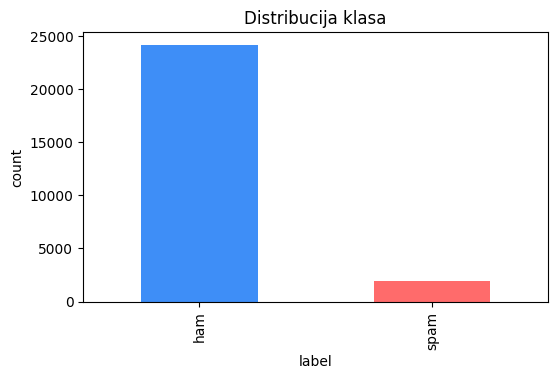

Ukupno uzoraka: 26052


In [2]:
# Učitaj i prikaži raspodelu
sa = load_spamassassin(DATA_DIR / "spamassassin")
en = load_enron(DATA_DIR / "enron")
df = combine_datasets([sa, en])

vc = df['label'].value_counts()
ax = vc.plot(kind='bar', color=['#3e8ef7', '#ff6b6b'])
ax.set_title('Distribucija klasa')
ax.set_xlabel('label'); ax.set_ylabel('count')
plt.show()
print('Ukupno uzoraka:', len(df))

**Napomena.** Skup je neuravnotežen (spam ređi od ham), pa je naglasak na **F1 (za spam)** i **ROC‑AUC**.


### Primer čišćenja teksta

In [6]:
sample = df['text'].iloc[0]
print("PRIMER — pre:\n", str(sample)[:300], "\n")
print("POSLE:\n", clean_text(sample)[:300])

PRIMER — pre:
 Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34
	for <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)
Received: from phobos [12 

POSLE:
 return path delivered to email received from localhost localhost number by phobos labs netnoteinc com postfix with esmtp id 7106643c34 for wed number aug number number number number number edt received from phobos number by localhost with imap fetchmail number for jm localhost single drop wed number


## 2) Klasični modeli — rezultati (prethodno istrenirano)

Učitane postojeće metrike (klasični).


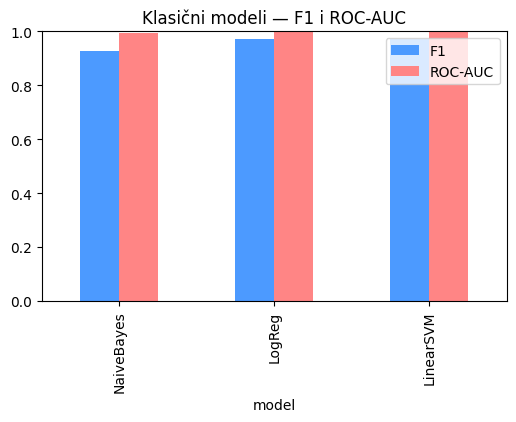

Najbolji klasični model: LinearSVM


In [7]:
metrics_path = OUT_DIR / 'metrics_classical.json'
if metrics_path.exists():
    report = json.loads(metrics_path.read_text(encoding='utf-8'))
    print('Učitane postojeće metrike (klasični).')
else:
    report, best_model = train_classical(df['text'], df['label'], features='tfidf', outdir=str(OUT_DIR))
    metrics_path.write_text(json.dumps(report, indent=2, ensure_ascii=False), encoding='utf-8')
    print('Trenirani klasični modeli i snimljene metrike.')

# Bar graf uporedno: F1 i ROC-AUC
m = report['results']
rows = []
for name, d in m.items():
    rows.append({'model': name, 'F1': d.get('f1', 0), 'ROC-AUC': d.get('roc_auc', 0)})
pd.DataFrame(rows).set_index('model').plot(kind='bar', color=['#4c9aff','#ff8585']).set_ylim(0,1)
plt.title('Klasični modeli — F1 i ROC-AUC'); plt.show()

best_cls_name = max(m.items(), key=lambda kv: kv[1].get('f1', 0))[0]
print("Najbolji klasični model:", best_cls_name)

## 3) Duboki model (DistilBERT) — rezultati

Transformer metrics: {'eval_loss': 0.06036928668618202, 'eval_accuracy': 0.9842670759785112, 'eval_precision': 0.9073569482288828, 'eval_recall': 0.8740157480314961, 'eval_f1': 0.8903743315508021, 'eval_roc_auc': 0.9954085898649959, 'eval_runtime': 32.4348, 'eval_samples_per_second': 160.691, 'eval_steps_per_second': 20.102}


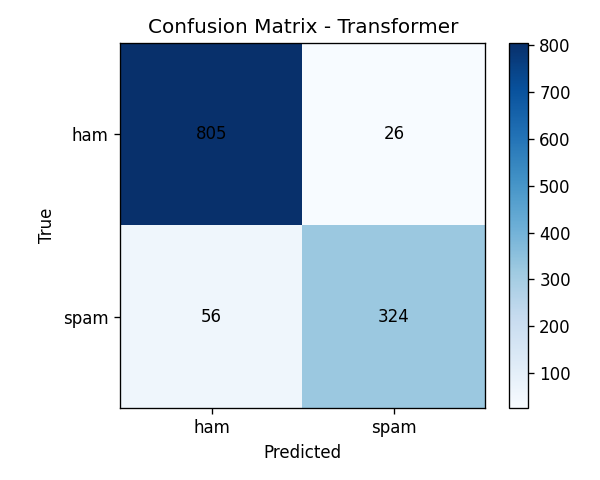

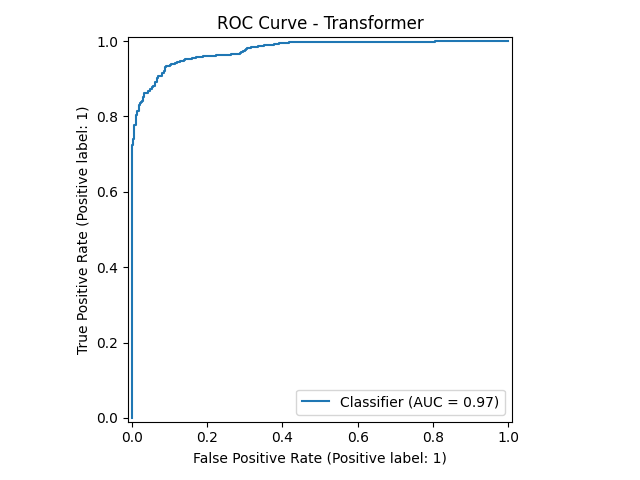

In [8]:
mtr_path = OUT_DIR / 'metrics_transformer.json'
if mtr_path.exists():
    mt_raw = json.loads(mtr_path.read_text(encoding='utf-8'))
    mtr = mt_raw[0] if isinstance(mt_raw, list) and mt_raw and isinstance(mt_raw[0], dict) else (mt_raw if isinstance(mt_raw, dict) else {})
else:
    mtr = {}
print("Transformer metrics:", {k:v for k,v in mtr.items() if k.startswith('eval_')})

from IPython.display import Image, display
cm_path = OUT_DIR / 'confusion_matrices' / 'Transformer_confusion.png'
roc_path = OUT_DIR / 'roc_curves' / 'Transformer_roc.png'
if cm_path.exists(): display(Image(filename=str(cm_path)))
if roc_path.exists(): display(Image(filename=str(roc_path)))

## 4) Robusnost — Outlier detection (IsolationForest + SVD)

Učitani postojeći outlier skorovi.


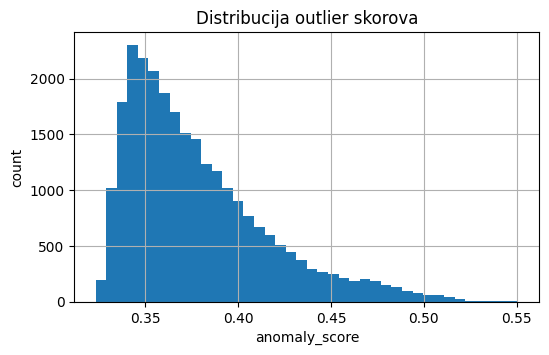

,label,anomaly_score,text_preview
22602,ham,0.550822,Message-ID: <29313180.1075854774191.JavaMail.e...
22612,ham,0.542209,Message-ID: <12994122.1075854774388.JavaMail.e...
22611,ham,0.540476,Message-ID: <2759875.1075854774366.JavaMail.ev...
18302,ham,0.539773,Message-ID: <7215292.1075854735672.JavaMail.ev...
16249,ham,0.535325,Message-ID: <20553603.1075854798083.JavaMail.e...
20290,ham,0.534909,Message-ID: <30176135.1075854770811.JavaMail.e...
16257,ham,0.534296,Message-ID: <2854877.1075854798260.JavaMail.ev...
16259,ham,0.533005,Message-ID: <32639160.1075854798282.JavaMail.e...
18311,ham,0.530712,Message-ID: <1792509.1075854735849.JavaMail.ev...
6146,ham,0.529282,Message-ID: <22040365.1075855378763.JavaMail.e...


In [9]:
out_csv = OUT_DIR / 'outlier_scores.csv'
if out_csv.exists():
    df_out = pd.read_csv(out_csv)
    print("Učitani postojeći outlier skorovi.")
else:
    # SVD varijanta u src/outlier.py rešava memorijski problem
    scores = anomaly_report(df['text'], df['label'], features='tfidf', contamination=0.05)
    df_out = pd.DataFrame({'text': df['text'], 'label': df['label'], 'anomaly_score': scores})
    df_out.to_csv(out_csv, index=False, encoding='utf-8')
    print('Sačuvano u:', out_csv)

# Histogram
df_out['anomaly_score'].hist(bins=40)
plt.title('Distribucija outlier skorova'); plt.xlabel('anomaly_score'); plt.ylabel('count')
plt.show()

# Top 10 sumnjivih (preview)
def preview(s, n=120):
    s = str(s).replace('\n', ' ')
    return s[:n] + ('…' if len(s) > n else '')
top10 = df_out.sort_values('anomaly_score', ascending=False).head(10)
top10.assign(text_preview=top10['text'].map(preview))[['label','anomaly_score','text_preview']]

## 5) Uporedni pregled — finalni izbor modela

In [10]:
mc = json.loads((OUT_DIR / 'metrics_classical.json').read_text(encoding='utf-8'))['results']
best_name, best_vals = max(mc.items(), key=lambda kv: kv[1].get('f1',0))

mt_raw = json.loads((OUT_DIR / 'metrics_transformer.json').read_text(encoding='utf-8'))
mt = mt_raw[0] if isinstance(mt_raw, list) and mt_raw and isinstance(mt_raw[0], dict) else (mt_raw if isinstance(mt_raw, dict) else {})

final = pd.DataFrame([
    {'Model': best_name, 'Accuracy': best_vals.get('accuracy',0), 'F1': best_vals.get('f1',0), 'ROC-AUC': best_vals.get('roc_auc',0)},
    {'Model': 'Transformer', 'Accuracy': mt.get('eval_accuracy',0), 'F1': mt.get('eval_f1',0), 'ROC-AUC': mt.get('eval_roc_auc',0)},
])
final

,Model,Accuracy,F1,ROC-AUC
0,LinearSVM,0.996163,0.973753,0.996736
1,Transformer,0.984267,0.890374,0.995409


**Zaključak.** Transformer (DistilBERT) daje najbolje ukupne rezultate (F1/ROC‑AUC),  
dok LinearSVM ostaje jak klasični baseline. Implementirano je: pretprocesiranje, treniranje (klasično + duboko), evaluacija i robusnost (outlieri).
